# Исследование на тему: "Определение неэффективных операторов"

###### Цель:

✆ Много пропущенных входящих вызовов.

✆ Долгое ожидания ответа при входящих внешних вызовах.

✆ Мало исходящих вывозов — в случае тех колл-центров, что специализируются на обзвонах, а не обработке входящих звонков.

###### Материалы:

Ссылка на дашбор: https://public.tableau.com/app/profile/.27502562/viz/Kozikoff_Artem/Dashboard1

Ссылка на призентацию: https://disk.yandex.ru/i/2tKxAc2q_AKrsg




##  Открытие файлов с данными и изучение общей информации

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math as mth
from datetime import datetime, time
from matplotlib import pyplot as plt
from plotly import graph_objects as go
from scipy import stats as st
from scipy.stats.mstats import mode
import scipy

Отключение ненужные предупреждения Python

In [2]:
import warnings
warnings.filterwarnings('ignore')

Откроем файлы с таблицами

In [3]:
clients = pd.read_csv('/datasets/telecom_clients.csv')

In [4]:
clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


Изучим информацию о датасете "clients"

In [5]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


Типы данных соответствуют ожидаемым, методом info пропущенных значений не обнаруженнно.

In [6]:
df = pd.read_csv('/datasets/telecom_dataset.csv')

In [7]:
df.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


Изучим информацию о датасете "df"

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


Несоответсвие типов данных ожидаемым в столбцах:

date - Ожидаемый тип datetime, а имеем object

internal - Лжидаемы тип bool, а имеем object

operator_id - Ожидаемый тип Int64, а имеем float64

Методом info обнаруженны пропуски в столбцах:

operator_id 

operator_id   

##  Предобработка данных

In [9]:
df.isnull().sum()

user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

В колонке internal всего 117 пропусков, что не может повлиять на исход иссследования, удалять пропуски считаю не целесообразно.

Изменим тип данных в колонке internal на соответсвующий, то есть на bool 

In [10]:
df['internal'] = df['internal'].astype('bool')

Проверим изменение

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53902 non-null  bool   
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(2), float64(1), int64(4), object(2)
memory usage: 3.0+ MB


Попробуем понять откуда взялось такое значительное количество пропущенных значений в колонке "operator_id".

In [12]:
nan_operator = df[df['operator_id'].isna()]

In [13]:
nan_operator.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35
9,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62
17,166377,2019-08-07 00:00:00+03:00,in,False,NaN,True,2,0,24
27,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34


In [14]:
nan_operator[nan_operator['direction']=='in'].count()

user_id                7972
date                   7972
direction              7972
internal               7972
operator_id               0
is_missed_call         7972
calls_count            7972
call_duration          7972
total_call_duration    7972
dtype: int64

In [15]:
nan_operator[nan_operator['direction']=='out'].count()

user_id                200
date                   200
direction              200
internal               200
operator_id              0
is_missed_call         200
calls_count            200
call_duration          200
total_call_duration    200
dtype: int64

Большинство пропусков приходится на входящие звонки.

In [16]:
nan_out = nan_operator[nan_operator['direction']=='out']
nan_out.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
455,166377,2019-11-06 00:00:00+03:00,out,False,NaN,True,1,0,1
2402,166407,2019-10-10 00:00:00+03:00,out,True,NaN,True,1,0,0
3241,166485,2019-10-15 00:00:00+03:00,out,True,NaN,True,2,0,8
3271,166485,2019-10-18 00:00:00+03:00,out,True,NaN,True,3,0,11
3276,166485,2019-10-18 00:00:00+03:00,out,True,NaN,True,3,0,11


In [17]:
nan_out[nan_out['is_missed_call']==True].count()

user_id                151
date                   151
direction              151
internal               151
operator_id              0
is_missed_call         151
calls_count            151
call_duration          151
total_call_duration    151
dtype: int64

In [18]:
out_call_false = nan_out[nan_out['is_missed_call']==False]
out_call_false.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
4089,166503,2019-09-26 00:00:00+03:00,out,False,NaN,False,1,213,220
4198,166503,2019-10-21 00:00:00+03:00,out,True,NaN,False,2,382,397
43756,168018,2019-11-05 00:00:00+03:00,out,False,NaN,False,1,978,984
43806,168018,2019-11-13 00:00:00+03:00,out,False,NaN,False,1,585,598
43850,168018,2019-11-26 00:00:00+03:00,out,False,NaN,False,1,229,246


In [19]:
out_call_false['user_id'].value_counts()

168252    44
168018     3
166503     2
Name: user_id, dtype: int64

151 случай пропущенных звонков при исходях вызовах у абонента с ID 168252. Что то явно с ним было не так как должно. Запомним этого обонента на будущее.

Рассмотрим часть пропущенных значений во входящих так как она более значительна.

In [20]:
nan_in = nan_operator[nan_operator['direction']=='in']
nan_in.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35
9,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62
17,166377,2019-08-07 00:00:00+03:00,in,False,NaN,True,2,0,24
27,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34


Рассмотрим пропуски значений во входящих звонках также с позиции пропущенных звонков.

In [21]:
nan_in['is_missed_call'].value_counts()

True     7899
False      73
Name: is_missed_call, dtype: int64

Большинство пропущенных значений во входящих вызовах соответствуют пропущенным звонкам.

Для составления общей картины посчитаем общее количество пропущенных звонков в основном датасете.

In [22]:
df['is_missed_call'].value_counts()

False    30334
True     23568
Name: is_missed_call, dtype: int64

В 8050 случаях из 23568  пропущенного звонка возникает пропуск значения в идентификации оператора. Сбой системы или человеческий фактор - не мешало бы сообщить об этом инженеру данных. 

На всякий случай, посмотрим на пропуски значений в идентификации операторов среди принятых входящих звонков.

In [23]:
in_call_false = nan_in[nan_in['is_missed_call']==False]
in_call_false.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
698,166399,2019-08-12 00:00:00+03:00,in,False,NaN,False,1,10,55
704,166399,2019-09-02 00:00:00+03:00,in,False,NaN,False,1,68,115
4136,166503,2019-10-09 00:00:00+03:00,in,False,NaN,False,1,374,405
12752,166782,2019-09-03 00:00:00+03:00,in,False,NaN,False,3,229,277
12757,166782,2019-09-03 00:00:00+03:00,in,False,NaN,False,3,229,277


In [24]:
in_call_false['user_id'].value_counts()

168252    45
166782    19
166399     2
166916     1
167819     1
168336     1
166946     1
167977     1
166503     1
167402     1
Name: user_id, dtype: int64

Вспомним ID клиентов с пропусками значений в идентификации операторов среди принятых исходящих звонков.

In [25]:
out_call_false['user_id'].value_counts()

168252    44
168018     3
166503     2
Name: user_id, dtype: int64

У клиента № "168252" наблюдается технический сбой, либо человеческий фактор по причине которого данные не сохраняются или же стираются из базы данных.

По результатам предварительного изучения данных, можно сделать вывод о том, что в преобладающем большинстве случаев пропуск значений возникает по причине пропущенного звонка. Мы не можем идентифицировать пропущенных операторов, но и удалять их тоже не хотелось бы, чтобы не потерять значительную часть всех наших данных. Заполним пропущенные значения в столбце operator_id самым часто встречающимся значением ID оператора по каждому клиенту.

In [26]:
mode =  df['operator_id'].mode()[0]
df['operator_id'] = df.groupby('user_id')\
['operator_id'].apply(lambda x: x.fillna(x.value_counts()\
                                         .idxmax() if x.value_counts().max() >=1 else mode , inplace = False))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53902 non-null  bool   
 4   operator_id          53902 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(2), float64(1), int64(4), object(2)
memory usage: 3.0+ MB


Заменим тип данных в столбце "operator_id"

In [27]:
df['operator_id'] = df['operator_id'].astype('int64')

Проверим датасет на дубликаты.

In [28]:
df.duplicated().sum()

4902

Избавимся от дубликатов.

In [29]:
df = df.drop_duplicates().reset_index(drop=True)

Изменим формат даты.

In [30]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.date
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49000 entries, 0 to 48999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              49000 non-null  int64         
 1   date                 49000 non-null  datetime64[ns]
 2   direction            49000 non-null  object        
 3   internal             49000 non-null  bool          
 4   operator_id          49000 non-null  int64         
 5   is_missed_call       49000 non-null  bool          
 6   calls_count          49000 non-null  int64         
 7   call_duration        49000 non-null  int64         
 8   total_call_duration  49000 non-null  int64         
dtypes: bool(2), datetime64[ns](1), int64(5), object(1)
memory usage: 2.7+ MB


Расчитаем дополнительные параметры.

✆ Длительность ожидания ответа на звонки;

✆ Длительность ожидания ответа на один звонок;

✆ Длительность одного звонка с учетом времени ожидания ответа на звонок;

✆ Длительность одного звонка без учета времени ожидания ответа на звонок.


In [31]:
df['waiting_time_answers'] = df['total_call_duration'] - df['call_duration']
df['waiting_time_one_answer'] = df['waiting_time_answers'] / df['calls_count']
df['one_call_duration_full'] = df['total_call_duration'] / df['calls_count']
df['one_call_duration_clean'] = df['call_duration'] / df['calls_count']
df.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time_answers,waiting_time_one_answer,one_call_duration_full,one_call_duration_clean
0,166377,2019-08-04,in,False,880028,True,2,0,4,4,2.000000,2.000000,0.0
1,166377,2019-08-05,out,True,880022,True,3,0,5,5,1.666667,1.666667,0.0
2,166377,2019-08-05,out,True,880020,True,1,0,1,1,1.000000,1.000000,0.0
3,166377,2019-08-05,out,True,880020,False,1,10,18,8,8.000000,18.000000,10.0
4,166377,2019-08-05,out,False,880022,True,3,0,25,25,8.333333,8.333333,0.0


### Предобработка таблицы telecom_clients.

In [32]:
clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


Убедимся в отсутствие пропусков.

In [33]:
clients.isna().sum()

user_id        0
tariff_plan    0
date_start     0
dtype: int64

Пропуски отсутствуют.

Проверим наличие дубликатов.

In [34]:
clients.duplicated().sum()

0

Дубликаты также отсутствуют.

Исправим тип данных в колонке date_start

In [35]:
clients['date_start'] = pd.to_datetime(clients['date_start'], format='%Y-%m-%d')
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB


Для дальнейшего удобства, объеденим датасеты.

In [36]:
df = df.merge(clients, on = 'user_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49000 entries, 0 to 48999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  49000 non-null  int64         
 1   date                     49000 non-null  datetime64[ns]
 2   direction                49000 non-null  object        
 3   internal                 49000 non-null  bool          
 4   operator_id              49000 non-null  int64         
 5   is_missed_call           49000 non-null  bool          
 6   calls_count              49000 non-null  int64         
 7   call_duration            49000 non-null  int64         
 8   total_call_duration      49000 non-null  int64         
 9   waiting_time_answers     49000 non-null  int64         
 10  waiting_time_one_answer  49000 non-null  float64       
 11  one_call_duration_full   49000 non-null  float64       
 12  one_call_duration_clean  49000 n

In [37]:
df.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time_answers,waiting_time_one_answer,one_call_duration_full,one_call_duration_clean,tariff_plan,date_start
0,166377,2019-08-04,in,False,880028,True,2,0,4,4,2.000000,2.000000,0.0,B,2019-08-01
1,166377,2019-08-05,out,True,880022,True,3,0,5,5,1.666667,1.666667,0.0,B,2019-08-01
2,166377,2019-08-05,out,True,880020,True,1,0,1,1,1.000000,1.000000,0.0,B,2019-08-01
3,166377,2019-08-05,out,True,880020,False,1,10,18,8,8.000000,18.000000,10.0,B,2019-08-01
4,166377,2019-08-05,out,False,880022,True,3,0,25,25,8.333333,8.333333,0.0,B,2019-08-01


Глянем на колонки с точки зрения наличия аномалий.

In [38]:
df['direction'].describe()

count     49000
unique        2
top         out
freq      28998
Name: direction, dtype: object

Text(0, 0.5, 'Количество')

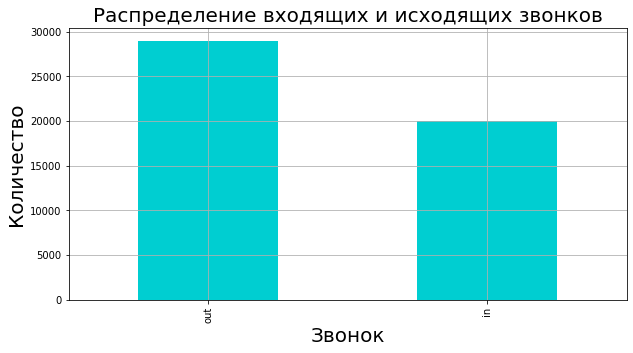

In [39]:
ax = df['direction'].value_counts().plot(kind='bar', grid=True, figsize=(10,5), color='#00CED1')
plt.title('Распределение входящих и исходящих звонков', color='#000000', fontsize=20)
plt.xlabel('Звонок', color='#000000', fontsize=20)
plt.ylabel('Количество', color='#000000', fontsize=20)

Исходящих звонком больше.

Взгянем на то, как обстоят дела с количеством звонков - в общем количестве и по направлению звонка.

In [40]:
df['calls_count'].describe()

count    49000.000000
mean        16.463408
std         63.605319
min          1.000000
25%          1.000000
50%          4.000000
75%         12.000000
max       4817.000000
Name: calls_count, dtype: float64

Распределение звонком неравномерно, среднее количество равно 16.463408, а медианна показывает число равное 4. Что по момему свидетельствует о наличие выбросов. Так же об этом нам говорит и количество минимальных 1 и максимальных 4817.

In [41]:
stat_out = df[df['direction']=='out']['calls_count']
stat_out.describe()

count    28998.000000
mean        20.996724
std         70.428417
min          1.000000
25%          2.000000
50%          5.000000
75%         18.000000
max       4817.000000
Name: calls_count, dtype: float64

In [42]:
stat_in = df[df['direction']=='in']['calls_count']
stat_in.describe()

count    20002.000000
mean         9.891211
std         51.448901
min          1.000000
25%          1.000000
50%          3.000000
75%          7.000000
max       2168.000000
Name: calls_count, dtype: float64

Картина по распределению количества звонков по направлению вызова в целом напоминает общую картину распределения числа звонков по операторам. За тем небольшим исключением, что исходящие вызовы демонстрируют больше выбросов. Построим ящик с усами для наглядности выбросов.

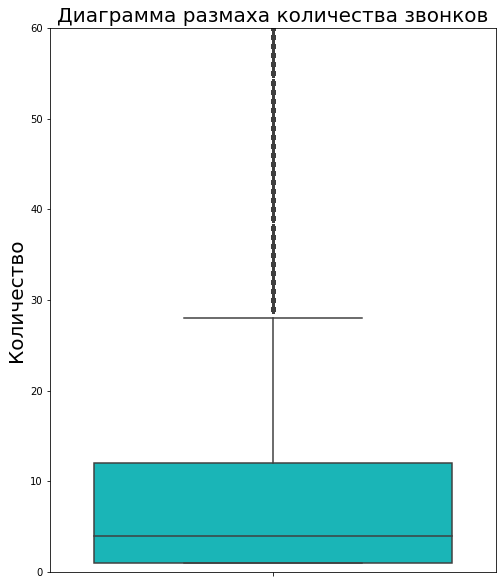

In [43]:
plt.figure(figsize=(8, 10))
plt.ylim(0, 60)
sns.boxplot(y="calls_count", data = df, color='#00CED1')
plt.title("Диаграмма размаха количества звонков", color='#000000', fontsize=20)
plt.ylabel("Количество", color='#000000', fontsize=20)
plt.show()

Граница выбросов примерно согласно диаграмме размаха начинается приблизительно около 28. Уберем из данных те строки где количество равно или более 28.

In [44]:
df = df.query('calls_count <= 28')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42953 entries, 0 to 48999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  42953 non-null  int64         
 1   date                     42953 non-null  datetime64[ns]
 2   direction                42953 non-null  object        
 3   internal                 42953 non-null  bool          
 4   operator_id              42953 non-null  int64         
 5   is_missed_call           42953 non-null  bool          
 6   calls_count              42953 non-null  int64         
 7   call_duration            42953 non-null  int64         
 8   total_call_duration      42953 non-null  int64         
 9   waiting_time_answers     42953 non-null  int64         
 10  waiting_time_one_answer  42953 non-null  float64       
 11  one_call_duration_full   42953 non-null  float64       
 12  one_call_duration_clean  42953 n

Посмотрим на распределение значений длительности одного звонка без учёта ожидания ответа, при условии, что продолжительность звонка равна или не равна нулевой. Посмотрим на это в разрезе пропущенных звонков.

In [45]:
df.query('one_call_duration_clean == 0')['is_missed_call'].value_counts()

True     18527
False       17
Name: is_missed_call, dtype: int64

In [46]:
df.query('one_call_duration_clean != 0')['is_missed_call'].value_counts()

False    24113
True       296
Name: is_missed_call, dtype: int64

В датафрейме df найдены 17 наблюдений, в которых находятся звонки не являющиеся пропущенными, но длительность разговора в которых составляет 0 секунд. Также есть 296 записей, в которых ненулевая длительность звонков, но запись обозначена как пропущенная. Вероятнее всего просто ошибка при загрузке данных в базу данных. Исключим эти данные для дальнейшего рассмотрения.

Инвертируем логические значения при помощи операции not, выраженной при помощи тильды (~).

In [47]:
df = (df[(~(df['one_call_duration_clean'] == 0) & (df['is_missed_call'] == False)) |
                  ((df['one_call_duration_clean'] == 0) & (df['is_missed_call'] == True))])
df.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time_answers,waiting_time_one_answer,one_call_duration_full,one_call_duration_clean,tariff_plan,date_start
0,166377,2019-08-04,in,False,880028,True,2,0,4,4,2.000000,2.000000,0.0,B,2019-08-01
1,166377,2019-08-05,out,True,880022,True,3,0,5,5,1.666667,1.666667,0.0,B,2019-08-01
2,166377,2019-08-05,out,True,880020,True,1,0,1,1,1.000000,1.000000,0.0,B,2019-08-01
3,166377,2019-08-05,out,True,880020,False,1,10,18,8,8.000000,18.000000,10.0,B,2019-08-01
4,166377,2019-08-05,out,False,880022,True,3,0,25,25,8.333333,8.333333,0.0,B,2019-08-01


Выводы предобработки.

Изменены типы данных:

✆ internal —  с object на bool;

✆ operator_id — с float64 на int64;

✆ date — c object на datetime64;

✆ date_start — c object на datetime64;

Найдены пропущенные значения (8172 пропуска):

Выявлены и удалены дубликаты в размере 9 % от размера датасета;

В таблицу добавлены колонки:

✆ waiting_time_answers - Длительность ожидания ответа на звонки

✆ waiting_time_one_answer - Длительность ожидания ответа на один звонок

✆ one_call_duration_full - Длительность одного звонка с учетом времени ожидания ответа на звонок

✆ one_call_duration_clean - Длительность одного звонка без учета времени ожидания ответа на звонок

Объеденены таблицы df и clients по колонке user_id;


## Исследовательский анализ данных.

Категоризация колл-центров (специализация на исходящих, входящих или смешанных звонках)

✆ Колл-центры, работающие на обзвон;

✆ Колл-центры, работающие на приём звонков;

✆ Колл-центры,работающие в смешанном режиме.


Создадим сводную таблицу, для категоризации.

In [48]:
df_pivot = df.pivot_table(index=['tariff_plan','user_id', 'operator_id', 'date', 'calls_count'], columns='direction', values='total_call_duration', aggfunc='sum')\
.reset_index()
df_pivot.head()

direction,tariff_plan,user_id,operator_id,date,calls_count,in,out
0,A,166407,888532,2019-08-20,1,NaN,16.0
1,A,166407,888532,2019-08-26,1,22.0,NaN
2,A,166407,888532,2019-09-09,6,NaN,22.0
3,A,166407,888532,2019-09-10,2,242.0,NaN
4,A,166407,888532,2019-09-11,1,39.0,NaN


In [49]:
df_pivot = df.pivot_table(
    index=[
        'tariff_plan',
        'user_id', 
        'operator_id', 
        'date', 
        'calls_count'
    ], 
    columns='direction',
    values='total_call_duration', 
    aggfunc='sum'
).reset_index()
df_pivot.head()

direction,tariff_plan,user_id,operator_id,date,calls_count,in,out
0,A,166407,888532,2019-08-20,1,NaN,16.0
1,A,166407,888532,2019-08-26,1,22.0,NaN
2,A,166407,888532,2019-09-09,6,NaN,22.0
3,A,166407,888532,2019-09-10,2,242.0,NaN
4,A,166407,888532,2019-09-11,1,39.0,NaN


Заменим nan в таблице на нули.

In [50]:
df_pivot = df_pivot.fillna(0)
df_pivot.head()

direction,tariff_plan,user_id,operator_id,date,calls_count,in,out
0,A,166407,888532,2019-08-20,1,0.0,16.0
1,A,166407,888532,2019-08-26,1,22.0,0.0
2,A,166407,888532,2019-09-09,6,0.0,22.0
3,A,166407,888532,2019-09-10,2,242.0,0.0
4,A,166407,888532,2019-09-11,1,39.0,0.0


Определим столбцы с долями для входящих и исходящих звонков.

In [51]:
df_pivot['call_in_perc'] = df_pivot['in'] / (df_pivot['in'] + df_pivot['out']) * 100
df_pivot['call_out_perc'] = df_pivot['out'] / (df_pivot['in'] + df_pivot['out']) * 100
df_pivot.head()

direction,tariff_plan,user_id,operator_id,date,calls_count,in,out,call_in_perc,call_out_perc
0,A,166407,888532,2019-08-20,1,0.0,16.0,0.0,100.0
1,A,166407,888532,2019-08-26,1,22.0,0.0,100.0,0.0
2,A,166407,888532,2019-09-09,6,0.0,22.0,0.0,100.0
3,A,166407,888532,2019-09-10,2,242.0,0.0,100.0,0.0
4,A,166407,888532,2019-09-11,1,39.0,0.0,100.0,0.0


Посмотрим на статистику распределения сумм секунд звонков среди операторов, затраченных на входящие и исходящие вызовы.

In [52]:
df_pivot['in'].describe()

count    38475.000000
mean       209.047122
std        577.346454
min          0.000000
25%          0.000000
50%          0.000000
75%        115.000000
max      15352.000000
Name: in, dtype: float64

In [53]:
df_pivot['out'].describe()

count    38475.000000
mean       354.522625
std        879.852640
min          0.000000
25%          0.000000
50%         22.000000
75%        275.000000
max      18283.000000
Name: out, dtype: float64

Наиболее приемлемым на мой взгялд произвести категоризацию по 75 % перцентилю.

Создадим новые колонки:

✆ incoming call - входящий вызов;

✆ outgoing call - исходящий вызов.

In [54]:
df_pivot['incoming call'] = df_pivot['call_in_perc'] >= 75
df_pivot['outgoing call'] = df_pivot['call_out_perc'] >= 75
df_pivot

direction,tariff_plan,user_id,operator_id,date,calls_count,in,out,call_in_perc,call_out_perc,incoming call,outgoing call
0,A,166407,888532,2019-08-20,1,0.0,16.0,0.0,100.0,False,True
1,A,166407,888532,2019-08-26,1,22.0,0.0,100.0,0.0,True,False
2,A,166407,888532,2019-09-09,6,0.0,22.0,0.0,100.0,False,True
3,A,166407,888532,2019-09-10,2,242.0,0.0,100.0,0.0,True,False
4,A,166407,888532,2019-09-11,1,39.0,0.0,100.0,0.0,True,False
...,...,...,...,...,...,...,...,...,...,...,...
38470,C,168606,957922,2019-11-09,4,0.0,593.0,0.0,100.0,False,True
38471,C,168606,957922,2019-11-10,1,0.0,38.0,0.0,100.0,False,True
38472,C,168606,957922,2019-11-11,2,0.0,501.0,0.0,100.0,False,True
38473,C,168606,957922,2019-11-15,4,0.0,3190.0,0.0,100.0,False,True


Для наглядности дальнейшей визуализации присвоим значениям False = 0, а True - 1.

In [55]:
df_pivot = df_pivot.replace(False, 0)   
df_pivot = df_pivot.replace(True, 1)    
df_pivot.head()

direction,tariff_plan,user_id,operator_id,date,calls_count,in,out,call_in_perc,call_out_perc,incoming call,outgoing call
0,A,166407,888532,2019-08-20,1,0.0,16.0,0.0,100.0,0,1
1,A,166407,888532,2019-08-26,1,22.0,0.0,100.0,0.0,1,0
2,A,166407,888532,2019-09-09,6,0.0,22.0,0.0,100.0,0,1
3,A,166407,888532,2019-09-10,2,242.0,0.0,100.0,0.0,1,0
4,A,166407,888532,2019-09-11,1,39.0,0.0,100.0,0.0,1,0


Создадим колонку со смешанными вызовами.

In [56]:
df_pivot['mixed challenge'] = 1 - df_pivot['incoming call'] - df_pivot['outgoing call'] 
df_pivot.head()

direction,tariff_plan,user_id,operator_id,date,calls_count,in,out,call_in_perc,call_out_perc,incoming call,outgoing call,mixed challenge
0,A,166407,888532,2019-08-20,1,0.0,16.0,0.0,100.0,0,1,0
1,A,166407,888532,2019-08-26,1,22.0,0.0,100.0,0.0,1,0,0
2,A,166407,888532,2019-09-09,6,0.0,22.0,0.0,100.0,0,1,0
3,A,166407,888532,2019-09-10,2,242.0,0.0,100.0,0.0,1,0,0
4,A,166407,888532,2019-09-11,1,39.0,0.0,100.0,0.0,1,0,0


Посмотрим чего тут у нас получилось.

In [57]:
call_pivot = df_pivot[['incoming call', 'outgoing call', 'mixed challenge']]
call_pivot.head()

direction,incoming call,outgoing call,mixed challenge
0,0,1,0
1,1,0,0
2,0,1,0
3,1,0,0
4,1,0,0


Построим гистограмму входящих, исходящих и смешанных звонков

Text(0, 0.5, 'Количество')

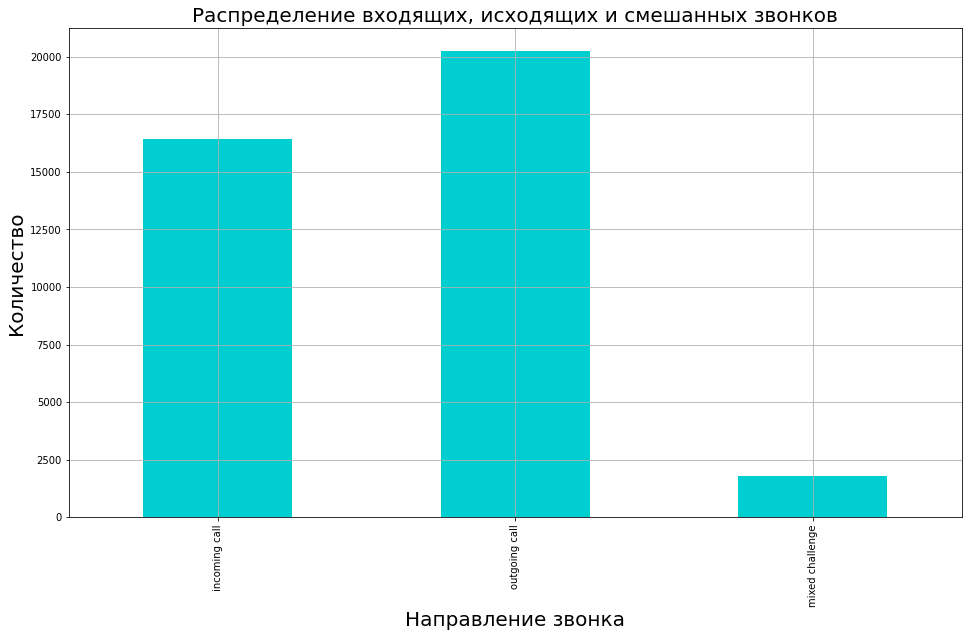

In [58]:
ax = call_pivot.sum().plot(kind='bar', grid=True, figsize=(16,9), color='#00CED1')
plt.title('Распределение входящих, исходящих и смешанных звонков', color='#000000', fontsize=20)
plt.xlabel('Направление звонка', color='#000000', fontsize=20)
plt.ylabel('Количество', color='#000000', fontsize=20)

Категоризация дала нам понять что лидируют по количеству колл-центры специализирующаяся на исходящих звонках. Сама малочесленная катогория это смешанные вызовы.

## Анализ нагрузки на операторов.

Рассмотрим нагрузку с двух позиций:

Максимальная продолжительность звонка по направлению вызова;

Максимальное количество вызовов.



В обоих случаях ожидается получить наличие/отсутствие связи между категориями колл-центров по датам.

In [59]:
df_pivot.head()

direction,tariff_plan,user_id,operator_id,date,calls_count,in,out,call_in_perc,call_out_perc,incoming call,outgoing call,mixed challenge
0,A,166407,888532,2019-08-20,1,0.0,16.0,0.0,100.0,0,1,0
1,A,166407,888532,2019-08-26,1,22.0,0.0,100.0,0.0,1,0,0
2,A,166407,888532,2019-09-09,6,0.0,22.0,0.0,100.0,0,1,0
3,A,166407,888532,2019-09-10,2,242.0,0.0,100.0,0.0,1,0,0
4,A,166407,888532,2019-09-11,1,39.0,0.0,100.0,0.0,1,0,0


Распределим операторов по трём образовавшимся категориям исходя из специализации работы колл-центра.

Начнём с тех, кто входит в категорию, специализирущуюся на входящих вызовах.

In [60]:
incoming_df = df_pivot[df_pivot['incoming call']==1]
incoming_df = incoming_df[['user_id', 'operator_id', 'in', 'date', 'calls_count']]
incoming_df.head()

direction,user_id,operator_id,in,date,calls_count
1,166407,888532,22.0,2019-08-26,1
3,166407,888532,242.0,2019-09-10,2
4,166407,888532,39.0,2019-09-11,1
27,166407,888532,802.0,2019-10-08,1
35,166407,888532,330.0,2019-10-16,1


Продолжим - датафрейм с операторами, входящими в категорию колл-центров, специализирующихся на исходящих вызовах.

In [61]:
outgoing_df = df_pivot[df_pivot['outgoing call']==1]
outgoing_df = outgoing_df[['user_id', 'operator_id', 'out', 'date', 'calls_count']]
outgoing_df.head()

direction,user_id,operator_id,out,date,calls_count
0,166407,888532,16.0,2019-08-20,1
2,166407,888532,22.0,2019-09-09,6
5,166407,888532,162.0,2019-09-11,7
6,166407,888532,50.0,2019-09-13,1
7,166407,888532,21.0,2019-09-16,1


Операторы из категории смешанных колл-центров.

In [62]:
mixed_df = df_pivot[df_pivot['mixed challenge']==1]
mixed_df = mixed_df[['user_id', 'operator_id', 'in', 'out', 'date', 'calls_count']]
mixed_df.head()

direction,user_id,operator_id,in,out,date,calls_count
39,166407,888532,187.0,89.0,2019-10-21,2
79,166407,888534,72.0,31.0,2019-09-11,1
88,166407,888534,57.0,37.0,2019-09-16,2
92,166407,888534,93.0,34.0,2019-09-18,2
95,166407,888534,32.0,22.0,2019-09-20,1


Изучим пиковые дни работы операторов, работающих со входящими звонками.

In [63]:
pik_date_in = incoming_df.set_index('date')['in'].sort_values(ascending=False).head(20)
pik_date_in

date
2019-11-20    15352.0
2019-11-12    14181.0
2019-11-14    13662.0
2019-11-11    13557.0
2019-11-13    13391.0
2019-11-08     8998.0
2019-11-23     8623.0
2019-10-28     8228.0
2019-11-18     7638.0
2019-11-26     7537.0
2019-11-01     7439.0
2019-11-06     7322.0
2019-09-16     7134.0
2019-09-13     7108.0
2019-09-23     6820.0
2019-09-16     6766.0
2019-11-25     6628.0
2019-11-18     6596.0
2019-11-15     6583.0
2019-10-24     6420.0
Name: in, dtype: float64

In [64]:
pik_date_in.describe()

count       20.000000
mean      8999.150000
std       3075.083435
min       6420.000000
25%       6806.500000
50%       7488.000000
75%      10096.250000
max      15352.000000
Name: in, dtype: float64

Text(0, 0.5, 'Продолжительность')

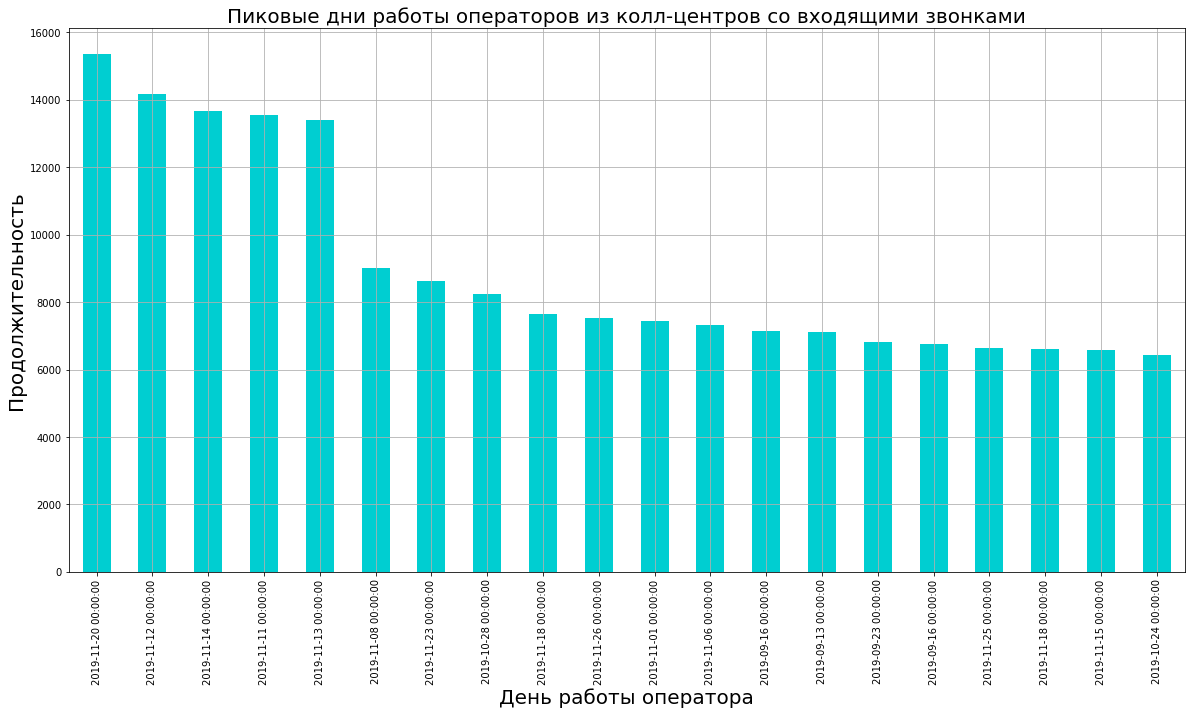

In [65]:
pik_date_in.plot(
    kind='bar',
    grid=True,
    figsize=(20, 10),color='#00CED1')

plt.title('Пиковые дни работы операторов из колл-центров со входящими звонками',color='#000000', fontsize=20)
plt.xlabel('День работы оператора',color='#000000', fontsize=20) 
plt.ylabel('Продолжительность',color='#000000', fontsize=20)   

В топ-5 пиковых дней работы операторов входящих звонков попадают:


✆ 11 ноября;

✆ 12 ноября;

✆ 13 ноября.

✆ 14 ноября;

✆ 20 ноября;





 




Посмотрим на общую картину работы операторов входящих звонков за весь период.

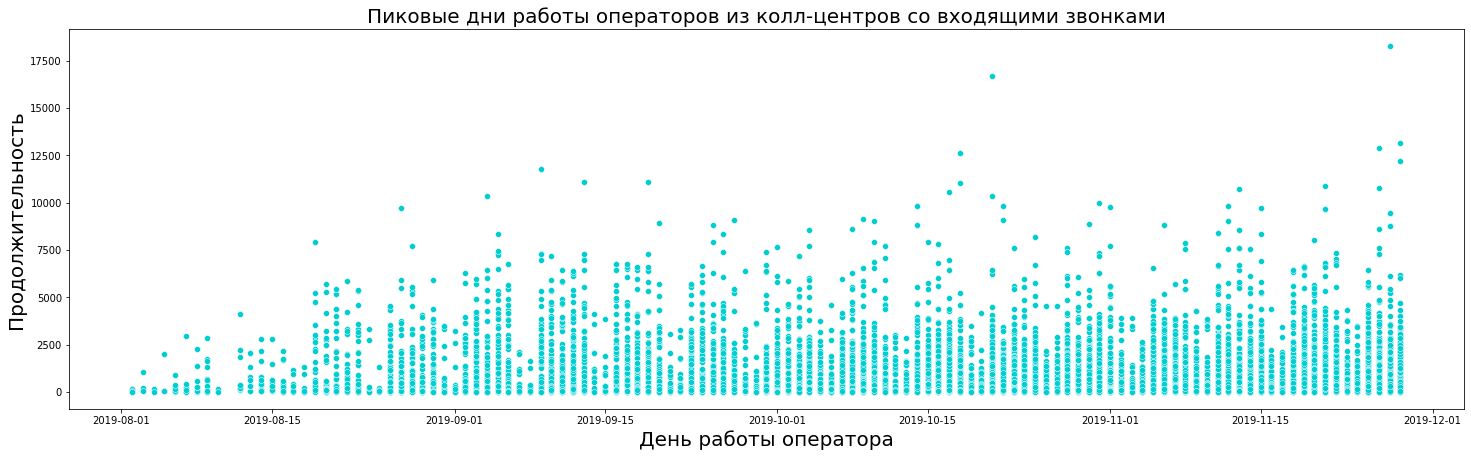

In [66]:
plt.figure(figsize=(25,7))
sns.scatterplot(x = 'date', y = 'out', data = outgoing_df,color='#00CED1')
plt.title('Пиковые дни работы операторов из колл-центров со входящими звонками', color='#000000', fontsize=20)
plt.xlabel('День работы оператора', color='#000000', fontsize=20), 
plt.ylabel('Продолжительность', color='#000000', fontsize=20)

plt.show()

Пик активности операторов входящих звонков расположен в дипазоне между 13 сентября 2019 года и 26 ноября 2019 года. Первый (менее выраженный) всплеск активности зарегистрирован со второй половины августа по начало октября. Октябрь 2019 года можно охарактеризовать как относительно спокойный месяц по сравнению с другими изучаемыми месяцами.


Посмотрим на загруженность работы операторов не с точки зрения продолжительности звонков, а с точки зрения их количества.

In [67]:
max_load_call_in_days = incoming_df.set_index('date').resample('M')['calls_count'].sum()
max_load_call_in_days.head()

date
2019-08-31     3060
2019-09-30    13312
2019-10-31    27984
2019-11-30    36580
Freq: M, Name: calls_count, dtype: int64

Text(0, 0.5, 'Количество звонков')

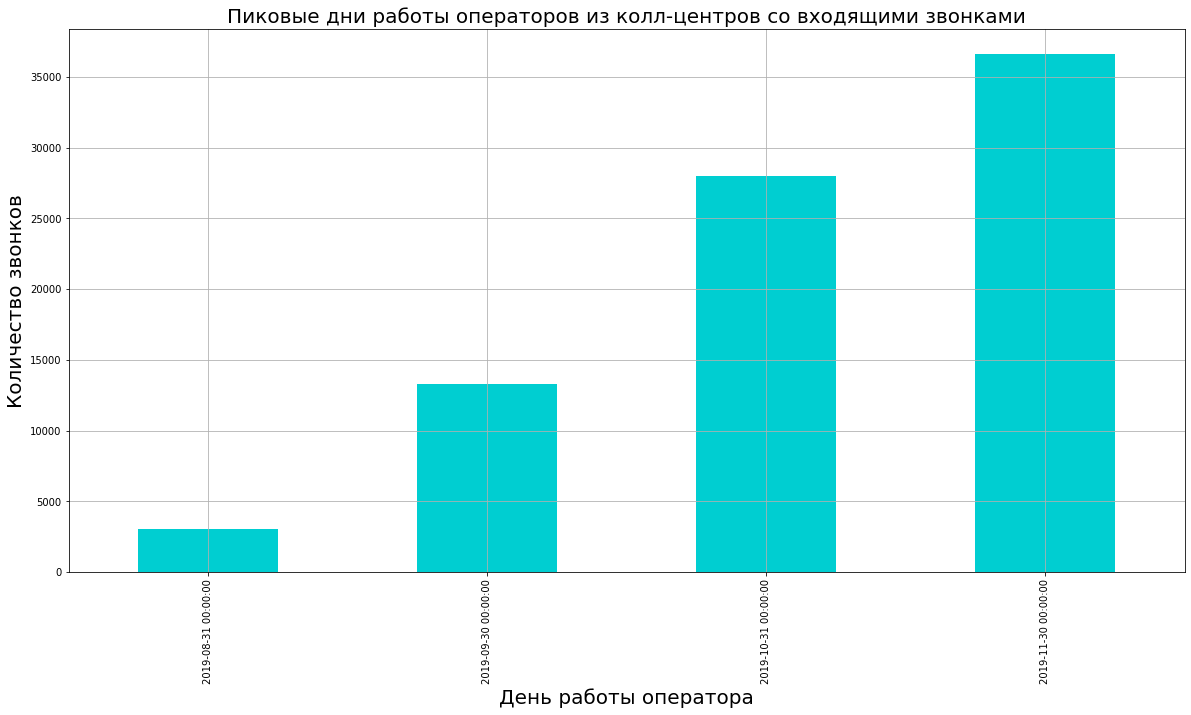

In [68]:
max_load_call_in_days.plot(
    kind='bar',
    grid=True,
    figsize=(20, 10),color='#00CED1')

plt.title('Пиковые дни работы операторов из колл-центров со входящими звонками',color='#000000', fontsize=20)
plt.xlabel('День работы оператора',color='#000000', fontsize=20) 
plt.ylabel('Количество звонков',color='#000000', fontsize=20)

Сравнение:

Максимальная длительность разговоров операторов с абонетами:

✆ 11 ноября;

✆ 12 ноября;

✆ 13 ноября;

✆ 14 ноября;

✆ 20 ноября.

Максимальное количество звонков поступивших операторам от абонентов:

✆ 31 августа;

✆ 30 сентября;

✆ 31 октября;

✆ 30 ноября.

Выводы:

Даты по количеству и продолжительности не совпадают.

Максимальное количество звонков было совершенно в каждый из последхих дней исследуемых месяцев.



Посмотрим, если такая же закономерность в 2 последующих группах. 

Исследуем  колл-центры, работающие с исходящими вызовами.

In [69]:
max_load_call_out_days = outgoing_df.set_index('date').resample('M')['calls_count'].sum()
max_load_call_out_days.head()

date
2019-08-31     6037
2019-09-30    24145
2019-10-31    49208
2019-11-30    68522
Freq: M, Name: calls_count, dtype: int64

Исследуем колл-центры, работающие в смешанном режиме.

In [70]:
max_load_call_mix_days = mixed_df.set_index('date').resample('M')['calls_count'].sum()
max_load_call_mix_days.head()

date
2019-08-31     175
2019-09-30     777
2019-10-31    1571
2019-11-30    2131
Freq: M, Name: calls_count, dtype: int64

Всё верно, совпадает. Обратим внимание и на то, что в обзвонах количество звонков в последние дни месяца превышает входящие звонки.

Посмотрим, совпадают ли дни максимальной нагрузки на операторов разных категорий с точки зрения максимальной продолжительности разговоров.

In [71]:
pik_date_out = outgoing_df.set_index('date')['out'].sort_values(ascending=False).head(20)
pik_date_out.head()

date
2019-11-27    18283.0
2019-10-21    16667.0
2019-11-28    13148.0
2019-11-26    12870.0
2019-10-18    12618.0
Name: out, dtype: float64

In [72]:
pik_date_out.describe()

count       20.000000
mean     11697.550000
std       2231.251324
min       9831.000000
25%      10355.500000
50%      10971.500000
75%      12312.750000
max      18283.000000
Name: out, dtype: float64

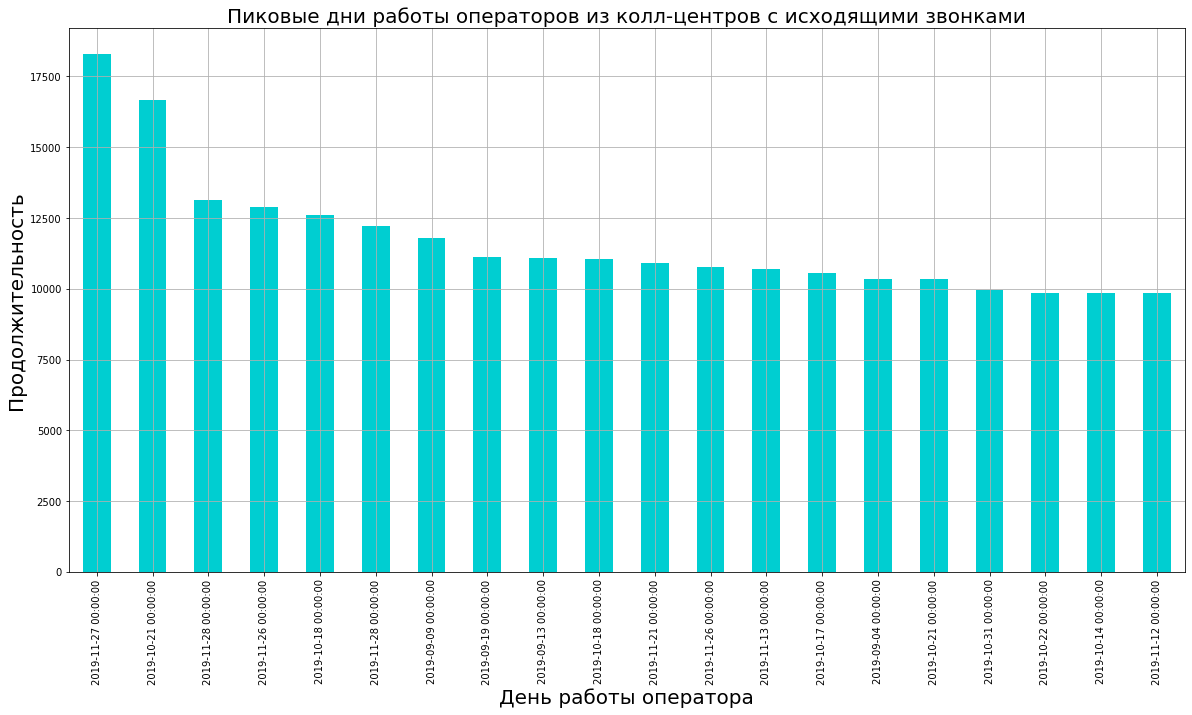

In [73]:
pik_date_out.plot(
    kind='bar',
    grid=True,
    figsize=(20, 10),color='#00CED1')
plt.title('Пиковые дни работы операторов из колл-центров с исходящими звонками',color='#000000', fontsize=20)
plt.xlabel('День работы оператора',color='#000000', fontsize=20) 
plt.ylabel('Продолжительность',color='#000000', fontsize=20)  
plt.show()

В топ-5 пиковых дней работы операторов исходящих звонков попадают:

✆ 27 ноября;

✆ 21 октября;

✆ 28 ноября;

✆ 26 ноября;

✆ 18 октября.


Напомним топ-5 пиковых дней работы операторов входящих звонков:

✆ 20 ноября;

✆ 12 ноября;

✆ 14 ноября;

✆ 11 ноября;

✆ 13 ноября.



Совпадения не наблюдаются.

Посмотрим на общую картину работы операторов исходящих звонков за весь период.

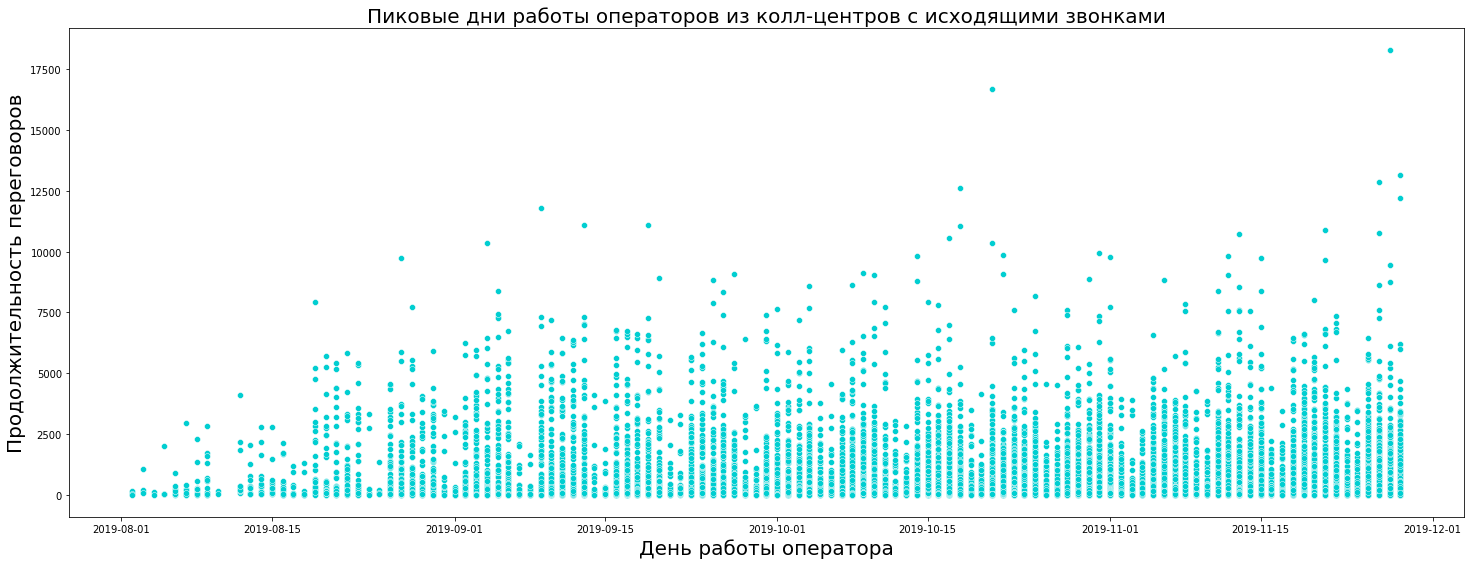

In [74]:
plt.figure(figsize=(25,9))
sns.scatterplot(x = 'date', y = 'out', data = outgoing_df, color='#00CED1')
plt.title('Пиковые дни работы операторов из колл-центров с исходящими звонками', color='#000000', fontsize=20)
plt.xlabel('День работы оператора', fontsize=20), 
plt.ylabel('Продолжительность переговоров', color='#000000', fontsize=20)
plt.show()

В целом, распределение продолжительности исходящих звонков выглядит более равномерной, чем распределение для входящих.

###### Промежуточные выводы:




Максимальное количество звонков было совершено в последний день каждого из зафиксированных месяцев.

Нагрузка на операторов (пиковые дни работы операторов) происходит каждый последний день месяца. Обратим также внимание на то, что в обзвонах количество звонков в последние дни месяца превышает входящие звонки в полтора-два-раза.

Исследование категорий колл-центров по признаку продолжительности разговоров не принесло ожидаемых результатов. 

Наличие связи между колл-центрами по признаку продолжительности разговоров по датам отсутствует.

## Выявление неэффективного оператора по целевым признакам.

Вспомним признаки низкой эффективности операторов:

✆ Много пропущенных входящих вызовов.

✆ Долгое ожидания ответа при входящих внешних вызовах.

✆ Мало исходящих вызовов — в случае тех колл-центров, что специализируются на обзвонах, а не обработке входящих звонков.

Для начала нужно определить значение "много" для пропущенных вызовов.

In [75]:
incoming_missed_call = df[(df['direction']=='in') & (df['is_missed_call']==True)]
incoming_missed_call.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time_answers,waiting_time_one_answer,one_call_duration_full,one_call_duration_clean,tariff_plan,date_start
0,166377,2019-08-04,in,False,880028,True,2,0,4,4,2.000000,2.000000,0.0,B,2019-08-01
7,166377,2019-08-05,in,False,880028,True,6,0,35,35,5.833333,5.833333,0.0,B,2019-08-01
8,166377,2019-08-06,in,False,880028,True,4,0,62,62,15.500000,15.500000,0.0,B,2019-08-01
16,166377,2019-08-07,in,False,880028,True,2,0,24,24,12.000000,12.000000,0.0,B,2019-08-01
26,166377,2019-08-12,in,False,880028,True,2,0,34,34,17.000000,17.000000,0.0,B,2019-08-01


In [76]:
pivot_missed_call = incoming_missed_call.pivot_table(index='operator_id', values='calls_count', aggfunc='sum').reset_index()\
.sort_values(by='calls_count', ascending=False)
pivot_missed_call.head()

,operator_id,calls_count
5,882686,920
29,890404,771
179,919552,612
180,919792,597
224,928888,595


Посмотрим статистику.

In [77]:
pivot_missed_call['calls_count'].describe()

count    379.000000
mean      78.179420
std      130.634489
min        1.000000
25%        4.000000
50%       23.000000
75%       83.500000
max      920.000000
Name: calls_count, dtype: float64

Постороим график того, как отображается распределение пропусков входящих вызовов операторами на графике

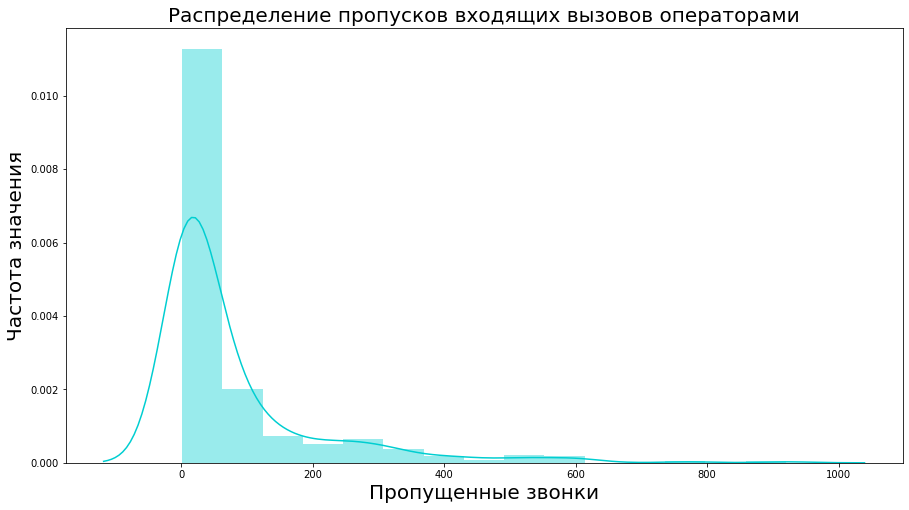

In [78]:
plt.figure(figsize=(15, 8))
sns.distplot(pivot_missed_call['calls_count'],color='#00CED1', bins = 15)
plt.title('Распределение пропусков входящих вызовов операторами', color='#000000', fontsize=20)
plt.xlabel("Пропущенные звонки",color='#000000', fontsize=20)
plt.ylabel("Частота значения",color='#000000', fontsize=20)
plt.show()

Для уточнения построим ящик с усами.

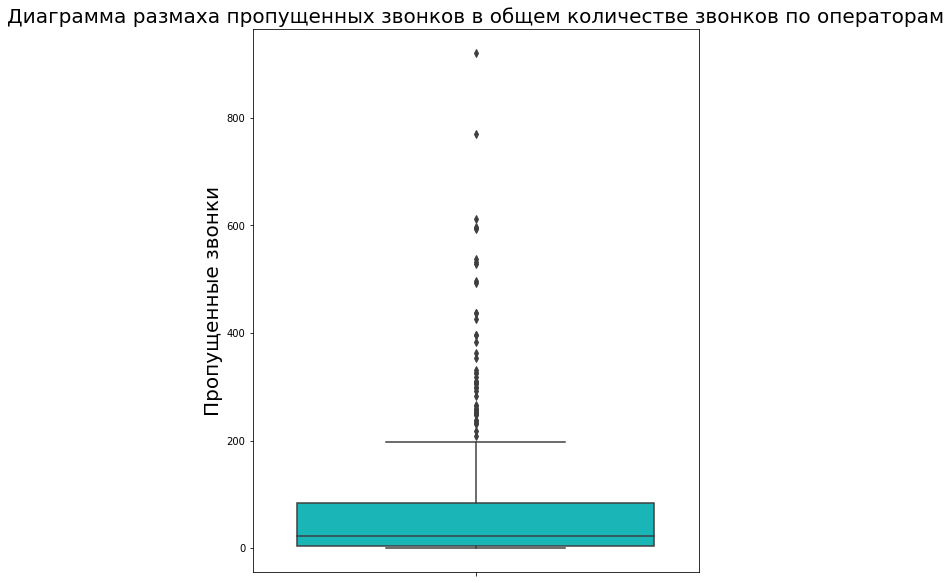

In [79]:
plt.figure(figsize=(8, 10))
sns.boxplot(y="calls_count", data = pivot_missed_call,color='#00CED1')
plt.title("Диаграмма размаха пропущенных звонков в общем количестве звонков по операторам", color='#000000', fontsize=20)
plt.ylabel("Пропущенные звонки", color='#000000', fontsize=20)
plt.show()

Согласно диаграмме размаха, выбросы начинаются после 200 пропущенных звонков. Используем эту информацию как критерий для сравнения с 80 % квантилью.

Восьмая квантиль является компромисом между началом выбросов (200) и третьей квартилью (83).



Выделим операторов попадающих под первый признак неэффективности - много пропущенных входящих вызовов. Определим понятие "много", как количество звонков явно превышающее третью квартиль, но меньшее порогов выбросов. В качестве такого ограничителя представляется корректным взять восьмую квантиль.

In [80]:
first_sign_of_inefficiency = pivot_missed_call.query('calls_count > calls_count.quantile(.8)')
first_sign_of_inefficiency.head()

,operator_id,calls_count
5,882686,920
29,890404,771
179,919552,612
180,919792,597
224,928888,595


Визуализируем деятельность неэффективных операторов, определённую по первому признаку - много пропущенных входящих вызовов.

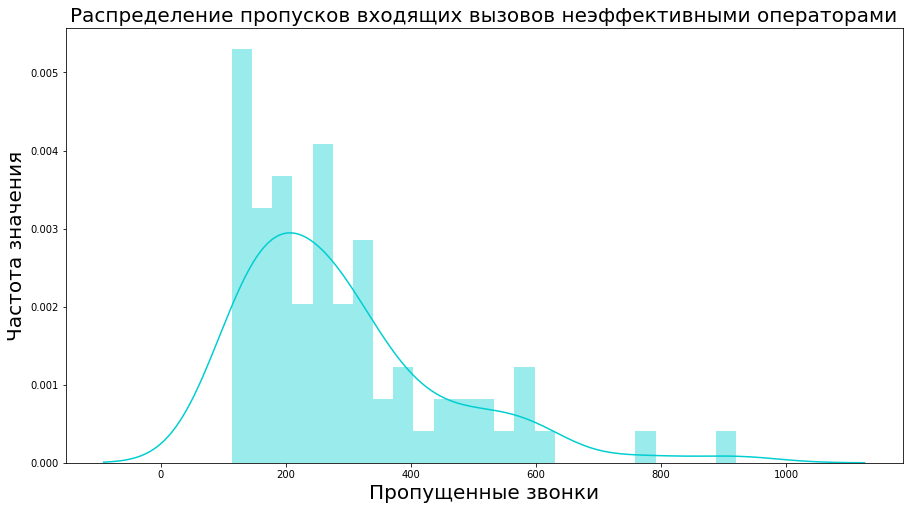

In [81]:
plt.figure(figsize=(15, 8))
sns.distplot(first_sign_of_inefficiency['calls_count'], color='#00CED1',bins = 25)
plt.title('Распределение пропусков входящих вызовов неэффективными операторами', color='#000000', fontsize=20)
plt.xlabel("Пропущенные звонки", color='#000000', fontsize=20)
plt.ylabel("Частота значения", color='#000000', fontsize=20)
plt.show()

По первому признаку неэффективности зафиксировано 76 операторов (20 % от числа всех операторов с пропущенными звонками) - операторы с пропуском входящих вызовов в совокупной сложности от 114 до 920.



Посмотрим на  второй признак низкой эффективности - долгое ожидание ответа при входящих внешних вызовах.

In [82]:
incoming_waiting_call = df.query('direction=="in"')
incoming_waiting_call.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time_answers,waiting_time_one_answer,one_call_duration_full,one_call_duration_clean,tariff_plan,date_start
0,166377,2019-08-04,in,False,880028,True,2,0,4,4,2.000000,2.000000,0.0,B,2019-08-01
7,166377,2019-08-05,in,False,880028,True,6,0,35,35,5.833333,5.833333,0.0,B,2019-08-01
8,166377,2019-08-06,in,False,880028,True,4,0,62,62,15.500000,15.500000,0.0,B,2019-08-01
16,166377,2019-08-07,in,False,880028,True,2,0,24,24,12.000000,12.000000,0.0,B,2019-08-01
25,166377,2019-08-12,in,False,880028,False,1,407,411,4,4.000000,411.000000,407.0,B,2019-08-01


In [83]:
pivot_waiting_call = incoming_waiting_call.pivot_table(index='operator_id', values='waiting_time_one_answer')\
.sort_values(by='waiting_time_one_answer', ascending=False).reset_index()
pivot_waiting_call.head()

,operator_id,waiting_time_one_answer
0,905842,115.5000
1,917680,100.0000
2,907174,65.1875
3,960296,63.0000
4,920930,62.0000


Посмотрим статистику.

In [84]:
pivot_waiting_call.describe()

,operator_id,waiting_time_one_answer
count,784.000000,784.000000
mean,923664.772959,17.817505
std,22489.185668,12.199307
min,879896.000000,0.285714
25%,905431.500000,9.877098
50%,924545.000000,15.000000
75%,940440.500000,22.728918
max,973286.000000,115.500000


Посмотрим, как отображается долгое ожидание ответа при входящих внешних вызовах.

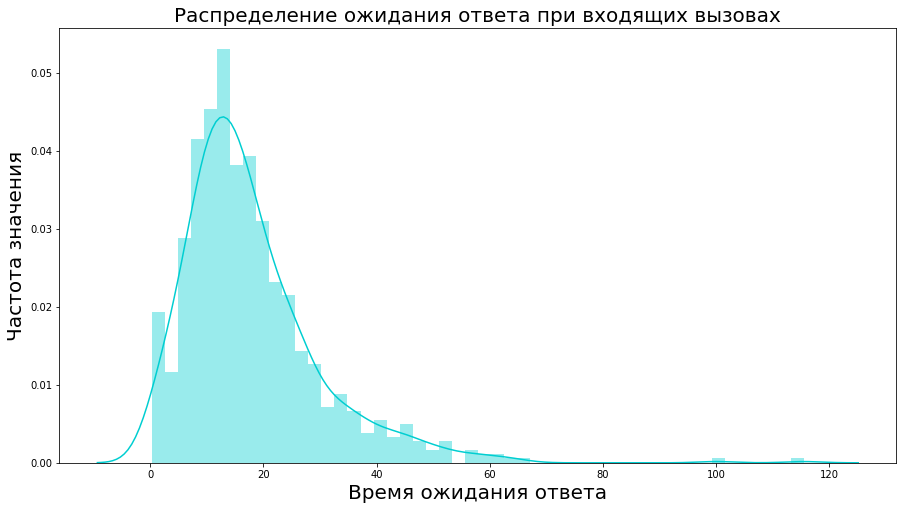

In [85]:
plt.figure(figsize=(15, 8))
sns.distplot(pivot_waiting_call['waiting_time_one_answer'], color='#00CED1',bins = 50)
plt.title('Распределение ожидания ответа при входящих вызовах', color='#000000', fontsize=20)
plt.xlabel("Время ожидания ответа", color='#000000', fontsize=20)
plt.ylabel("Частота значения", color='#000000', fontsize=20)
plt.show()

Для уточнения построим ящик с усами.

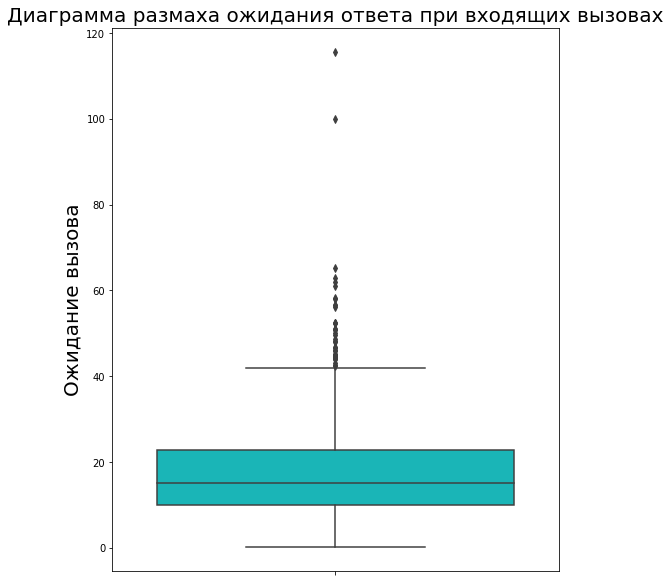

In [86]:
plt.figure(figsize=(8, 10))
sns.boxplot(y="waiting_time_one_answer", data = pivot_waiting_call, color='#00CED1')
plt.title("Диаграмма размаха ожидания ответа при входящих вызовах", color='#000000', fontsize=20)
plt.ylabel("Ожидание вызова", color='#000000', fontsize=20)
plt.show()

Согласно диаграмме размаха выбросы начинаются после 40 секунд ожидания ответа. Сравним этот показатель с восьмой квантилью.

In [87]:
pivot_waiting_call['waiting_time_one_answer'].quantile(.8)

25.0

Выделим операторов попадающих под второй признак неэффективности - долгое ожидания ответа при входящих внешних вызовах. Определим понятие "долгое", как ожидание превышающее 25 секунд

In [88]:
second_sign_of_inefficiency = pivot_waiting_call[pivot_waiting_call['waiting_time_one_answer']>25].reset_index()
second_sign_of_inefficiency.head()

,index,operator_id,waiting_time_one_answer
0,0,905842,115.5000
1,1,917680,100.0000
2,2,907174,65.1875
3,3,960296,63.0000
4,4,920930,62.0000


Визуализируем деятельность неэффективных операторов, определённую по второму признаку - долгое ожидания ответа при входящих внешних вызовах.

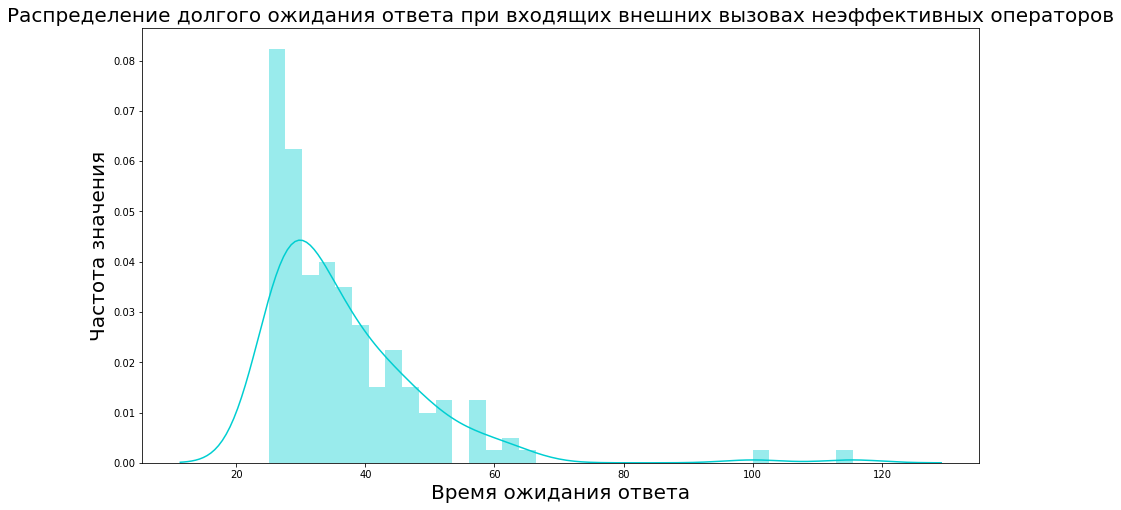

In [89]:
plt.figure(figsize=(15, 8))
sns.distplot(second_sign_of_inefficiency['waiting_time_one_answer'], color='#00CED1', bins = 35)
plt.title('Распределение долгого ожидания ответа при входящих внешних вызовах неэффективных операторов', color='#000000', fontsize=20)
plt.xlabel("Время ожидания ответа", color='#000000', fontsize=20)
plt.ylabel("Частота значения", color='#000000', fontsize=20)
plt.show()

По второму признаку неэффективности зафиксировано 153 оператора заставляющие ждать ответа от 25 секунд до 115 секунд.

Изучим третий признак неэффективности - мало исходящих вызовов.

In [90]:
outgoing_few_calls = df[df['direction']=='out']
outgoing_few_calls.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time_answers,waiting_time_one_answer,one_call_duration_full,one_call_duration_clean,tariff_plan,date_start
1,166377,2019-08-05,out,True,880022,True,3,0,5,5,1.666667,1.666667,0.0,B,2019-08-01
2,166377,2019-08-05,out,True,880020,True,1,0,1,1,1.000000,1.000000,0.0,B,2019-08-01
3,166377,2019-08-05,out,True,880020,False,1,10,18,8,8.000000,18.000000,10.0,B,2019-08-01
4,166377,2019-08-05,out,False,880022,True,3,0,25,25,8.333333,8.333333,0.0,B,2019-08-01
5,166377,2019-08-05,out,False,880020,False,2,3,29,26,13.000000,14.500000,1.5,B,2019-08-01


In [91]:
pivot_few_calls = outgoing_few_calls.pivot_table(index='operator_id', values='calls_count', aggfunc='sum').reset_index()
pivot_few_calls.head()

,operator_id,calls_count
0,879896,447
1,879898,886
2,880020,38
3,880022,189
4,880026,1919


Посмотрим на статистику.

In [92]:
pivot_few_calls.describe()

,operator_id,calls_count
count,873.000000,873.000000
mean,925658.703322,180.499427
std,22936.762141,300.257925
min,879896.000000,1.000000
25%,906392.000000,10.000000
50%,924960.000000,52.000000
75%,944210.000000,224.000000
max,973120.000000,2127.000000


Визуализируем распределение исходящих звонков по количеству за весь период

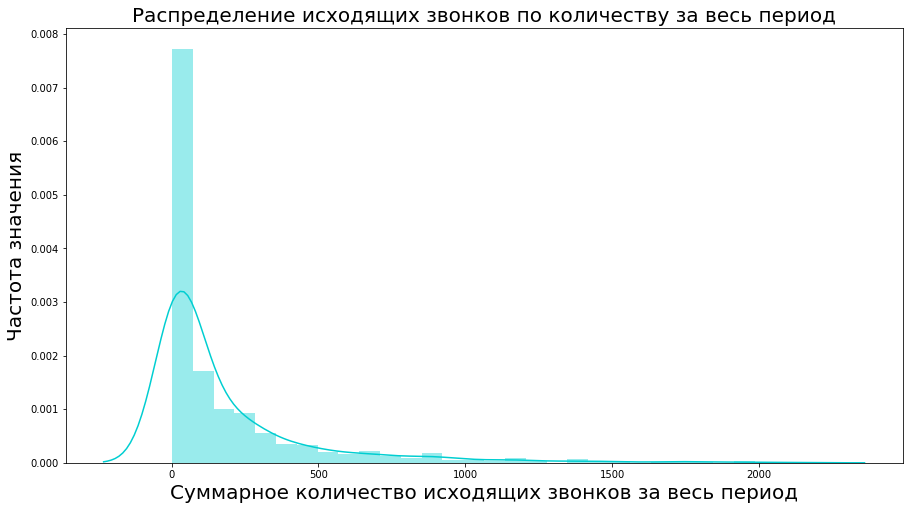

In [93]:
plt.figure(figsize=(15, 8))
sns.distplot(pivot_few_calls['calls_count'], color='#00CED1',bins = 30)
plt.title('Распределение исходящих звонков по количеству за весь период', color='#000000', fontsize=20)
plt.xlabel("Суммарное количество исходящих звонков за весь период", color='#000000', fontsize=20)
plt.ylabel("Частота значения", color='#000000', fontsize=20)
plt.show()

В первую квартиль попадает 10 звонков, совершённых оператором за весь период. Посмотрим на выбросы.

Для уточнения построим ящик с усами.

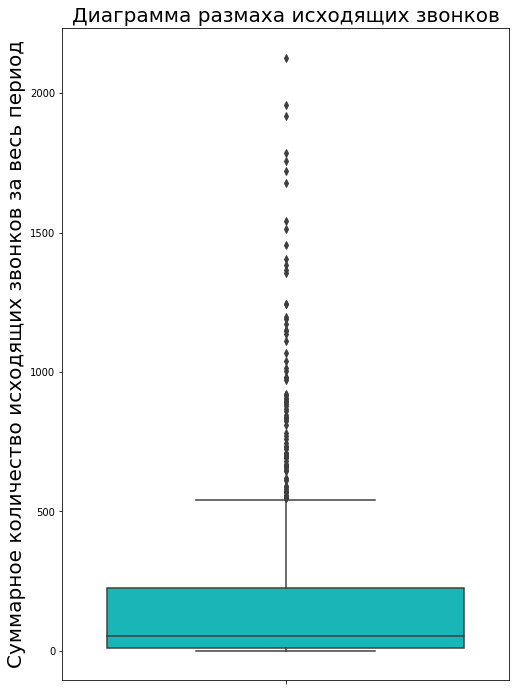

In [94]:
plt.figure(figsize=(8, 12))
sns.boxplot(y="calls_count", data = pivot_few_calls, color='#00CED1')
plt.title("Диаграмма размаха исходящих звонков", color='#000000', fontsize=20)
plt.ylabel("Суммарное количество исходящих звонков за весь период", color='#000000', fontsize=20)
plt.show()

Диаграмма размаха демонстрирует выбросы в большую сторону более 500. Нас интересует минимальное количество. Посмотрим на диаграмму размаха без значений, превышающих медиану.

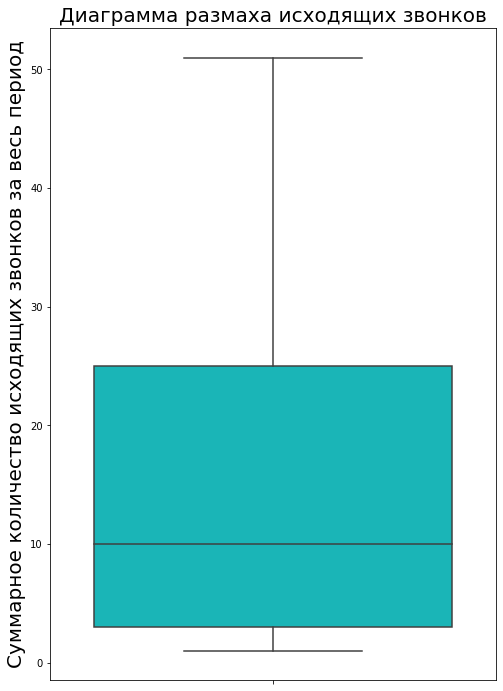

In [95]:
plt.figure(figsize=(8, 12))
sns.boxplot(y="calls_count", data = pivot_few_calls.query('calls_count < calls_count.median()'), color='#00CED1')
plt.title("Диаграмма размаха исходящих звонков", color='#000000', fontsize=20)
plt.ylabel("Суммарное количество исходящих звонков за весь период", color='#000000', fontsize=20)
plt.show()

Выделим операторов попадающих под третий признак неэффективности - мало исходящих вызовов. Определим понятие "мало", как менее или равно 10 %, переданные в качестве аргумента методу quantile

In [96]:
pivot_few_calls['calls_count'].quantile(.1)

2.0

In [97]:
third_sign_of_inefficiency = pivot_few_calls[pivot_few_calls['calls_count']\
                                                 <=pivot_few_calls['calls_count']\
                                                 .quantile(.1)]
third_sign_of_inefficiency

,operator_id,calls_count
8,882478,1
13,883018,2
14,883898,1
45,890234,1
64,891192,1
...,...,...
854,969288,2
859,970240,1
861,970244,2
862,970250,1


Визуализируем деятельность неэффективных операторов, определённую по третьему признаку - мало исходящих вызовов.

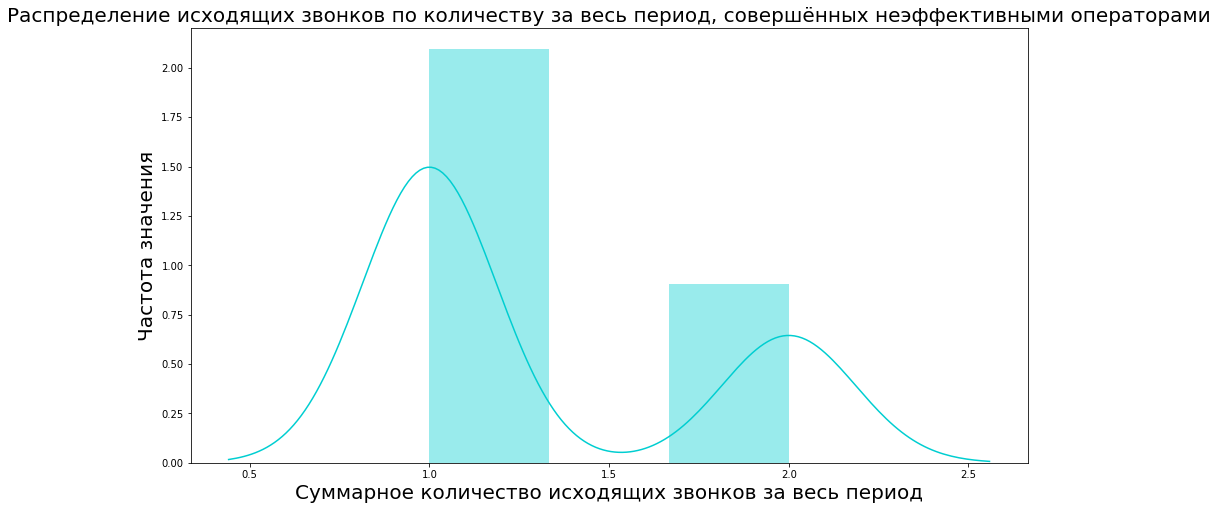

In [98]:
plt.figure(figsize=(15, 8))
sns.distplot(third_sign_of_inefficiency['calls_count'], color='#00CED1')
plt.title('Распределение исходящих звонков по количеству за весь период, совершённых неэффективными операторами', color='#000000', fontsize=20)
plt.xlabel("Суммарное количество исходящих звонков за весь период", color='#000000', fontsize=20)
plt.ylabel("Частота значения", color='#000000', fontsize=20)
plt.show()

По третьему признаку неэффективности зафиксировано 93 оператора совершившие в совокупной сложности от 1 до 2 звонков за весь период.

Выделим тех операторов, которые входят в группу неэффективных по двум первым признакам.

✆ Много пропущенных входящих вызовов.

✆ Долгое ожидания ответа при входящих внешних вызовах.

In [99]:
inefficient_incoming_operators = first_sign_of_inefficiency.merge(second_sign_of_inefficiency, on='operator_id')
inefficient_incoming_operators

,operator_id,calls_count,index,waiting_time_one_answer
0,919552,612,68,34.835725
1,919792,597,80,33.083651
2,902744,437,154,25.027655
3,924960,308,122,27.506334
4,887276,292,145,25.744289
5,944220,253,78,33.295919
6,894224,250,96,30.264258
7,899932,233,82,32.716512
8,892532,230,135,26.462563
9,906680,218,30,44.597599


В итоговую таблицу по неэффективным операторам, принимающим входящие звонки попали 12 операторов.

Вспомним третий признак неэффективности - мало исходящих вызовов — в случае тех колл-центров, что специализируются на обзвонах, а не обработке входящих звонков.

Согласно условию изучим операторов из третьего признака с учётом вхождения их в категорию колл-центров, специализирующихся на обзвонах.

In [100]:
inefficient_outgoing_operators = third_sign_of_inefficiency.merge(outgoing_df, on='operator_id')
inefficient_outgoing_operators

,operator_id,calls_count_x,user_id,out,date,calls_count_y
0,883018,2,166507,15.0,2019-08-07,2
1,883898,1,166507,80.0,2019-08-07,1
2,890234,1,166520,97.0,2019-08-17,1
3,891192,1,166520,1338.0,2019-08-25,1
4,891250,2,166711,128.0,2019-08-20,2
...,...,...,...,...,...,...
68,969284,1,168336,4.0,2019-11-25,1
69,969288,2,168155,21.0,2019-11-24,2
70,970244,2,168225,23.0,2019-11-28,1
71,970250,1,168225,8.0,2019-11-28,1


In [101]:
inefficient_outgoing_operators['operator_id'].unique()

array([883018, 883898, 890234, 891192, 891250, 891918, 891976, 895598,
       899076, 905480, 906076, 907998, 908834, 914256, 914272, 917858,
       917890, 919206, 919214, 919418, 924572, 928282, 928284, 929542,
       930326, 930510, 930816, 930820, 932246, 934426, 937366, 937710,
       937716, 937720, 937770, 937772, 937778, 937872, 940610, 940814,
       940842, 940848, 941816, 941826, 944246, 944560, 945058, 945274,
       947596, 952196, 952462, 954086, 954284, 954318, 955086, 955094,
       956292, 960666, 962904, 963716, 964666, 966686, 969262, 969284,
       969288, 970244, 970250, 970258], dtype=int64)

In [102]:
len(inefficient_outgoing_operators['operator_id'].unique())

68

В итоговую таблицу неэффективных операторов с учётом вхождения их в категорию колл-центров, специализирующихся на обзвонах, попали 68 уникальных оператора.

In [103]:
inefficient_outgoing_operators['operator_id'].nunique()

68

###### Выводы:

Напомним признаки неуспешности оператора:

✆ Много пропущенных входящих вызовов.

✆ Долгое ожидания ответа при входящих внешних вызовах.

✆ Мало исходящих вызовов — в случае тех колл-центров, что специализируются на обзвонах, а не обработке входящих звонков.

В процессе исследования деятельности неуспешных операторов бало выявлено:

✆ По первому признаку неэффективности зафиксировано 76 операторов с пропуском входящих вызовов в совокупной сложности от 114 до 920.

✆ По второму признаку неэффективности зафиксировано 153 оператора заставляющие ждать ответа от 25 секунд до 115 секунд.

✆ По третьему признаку неэффективности зафиксировано 93 оператора совершившие в совокупной сложности от 1 до 2 звонков за весь период.

✆ В итоговую таблицу по неэффективным операторам, принимающим входящие звонки попали 12 операторов. 

✆ В итоговую таблицу неэффективных операторов специализирующихся на обзвонах, попали 68 уникальных оператора. 





## Формулировка и проверка статистических гипотез.

Проверка данных на нормальность распределения данных.

✆ Н0: Данные распределены нормально.

✆ Н1: Данные не имеют нормального распределения.

Гипотеза #1

✆ Н0: Время ожидания звонка зависит от тарифного плана;

✆ Н1: Время ожидания звонка не зависит от тарифного плана.

Проведем первый критерий Шапиро-Уилк, возвращающий значение вычисленной статистики и p-значение. В качестве критического значения в большинстве случаев берется 0.05. При p-значении меньше 0.05 мы вынуждены отклонить нулевую гипотезу.

In [104]:
stat, p = scipy.stats.shapiro(df.query('tariff_plan == "A" and is_missed_call == False and internal == True')\
['waiting_time_one_answer'])
                              
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
                              
if p > alpha:
    print('Принять гипотезу о нормальности') 
                                 
else:
    print('Отклонить гипотезу о нормальности') 

Statistics=0.766, p-value=0.000
Отклонить гипотезу о нормальности


In [105]:
stat, p = scipy.stats.shapiro(df.query('tariff_plan == "B" and is_missed_call == False and internal == True')\
['waiting_time_one_answer'])
                              
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
                              
if p > alpha:
    print('Принять гипотезу о нормальности') 
                                 
else:
    print('Отклонить гипотезу о нормальности')

Statistics=0.703, p-value=0.000
Отклонить гипотезу о нормальности


In [106]:
stat, p = scipy.stats.shapiro(df.query('tariff_plan == "C" and is_missed_call == False and internal == True')\
['waiting_time_one_answer'])
                              
print('Statistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
                              
if p > alpha:
    print('Принять гипотезу о нормальности') 
                                 
else:
    print('Отклонить гипотезу о нормальности')

Statistics=0.737, p-value=0.000
Отклонить гипотезу о нормальности


Распределение данных не является нормальным.

Гипотеза #1

✆ Н0: Время ожидания звонка зависит от тарифного плана;

✆ Н1: Время ожидания звонка не зависит от тарифного плана.

Проверим, существуют ли статистически достоверные различия между выборками с разными тарифными планами. Для этого сравним попарно тарифные планы "А", "В" и "С" между собой.

Сформулируем промежуточные гипотезы:



✆ Н0: время ожидания звонка тарифного плана "А" равно времени ожидания звонка тарифного плана "В"
    
✆ Н1: время ожидания звонка тарифного плана "А" не равно времени ожидания звонка тарифного плана "В"

In [107]:
alpha = 0.05

results = st.mannwhitneyu(
    df.query('tariff_plan == "A" and is_missed_call == False and internal == True')['waiting_time_one_answer'], 
    df.query('tariff_plan == "B" and is_missed_call == False and internal == False')['waiting_time_one_answer'],
    )

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")    

p-значение: 4.906347007761984e-134
Отвергаем нулевую гипотезу


In [108]:
df.query('tariff_plan == "A" and is_missed_call == False and internal == True')['waiting_time_one_answer'].describe()

count    1282.000000
mean        9.908103
std         7.625168
min         0.000000
25%         5.500000
50%         8.000000
75%        12.000000
max        82.000000
Name: waiting_time_one_answer, dtype: float64

In [109]:
df.query('tariff_plan == "B" and is_missed_call == False and internal == True')['waiting_time_one_answer'].describe()

count    838.000000
mean       7.260587
std        6.496939
min        0.000000
25%        3.250000
50%        5.000000
75%        8.729167
max       59.000000
Name: waiting_time_one_answer, dtype: float64

Пришлось отвергнуть нулевую гипотезу, значит существуют статистически достоверные различия между тарифными планами "А" и "В". 

Метод describe() демонстрирует эти отличия.

Сформулируем промежуточные гипотезы:

✆ Н0: время ожидания звонка тарифного плана "В" равно времени ожидания звонка тарифного плана "С"
    
✆ Н1: время ожидания звонка тарифного плана "В" не равно времени ожидания звонка тарифного плана "С"

In [110]:
alpha = 0.05

results = st.mannwhitneyu(
    df.query('tariff_plan == "B" and is_missed_call == False and internal == True')['waiting_time_one_answer'], 
    df.query('tariff_plan == "C" and is_missed_call == False and internal == False')['waiting_time_one_answer'],
    )

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.5913160301211356e-180
Отвергаем нулевую гипотезу


In [111]:
df.query('tariff_plan == "B" and is_missed_call == False and internal == True')['waiting_time_one_answer'].describe()

count    838.000000
mean       7.260587
std        6.496939
min        0.000000
25%        3.250000
50%        5.000000
75%        8.729167
max       59.000000
Name: waiting_time_one_answer, dtype: float64

In [112]:
df.query('tariff_plan == "C" and is_missed_call == False and internal == True')['waiting_time_one_answer'].describe()

count    854.000000
mean       8.442495
std        6.911003
min        0.000000
25%        4.000000
50%        6.571429
75%       10.000000
max       66.000000
Name: waiting_time_one_answer, dtype: float64

Отвергаем нулевую гипотезу, тарифные планы "В" и "С" статистически значимо отличаются друг от друга по времени ожидания звонка. 

Сформулируем промежуточные гипотезы:

✆ Н0: время ожидания звонка тарифного плана "А" равно времени ожидания звонка тарифного плана "С"
    
✆ Н1: время ожидания звонка тарифного плана "А" не равно времени ожидания звонка тарифного плана "С"

In [113]:
alpha = 0.05

results = st.mannwhitneyu(
    df.query('tariff_plan == "A" and is_missed_call == False and internal == True')['waiting_time_one_answer'], 
    df.query('tariff_plan == "C" and is_missed_call == False and internal == False')['waiting_time_one_answer'],
    )

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.1884111683591517e-108
Отвергаем нулевую гипотезу


In [114]:
df.query('tariff_plan == "A" and is_missed_call == False and internal == True')['waiting_time_one_answer'].describe()

count    1282.000000
mean        9.908103
std         7.625168
min         0.000000
25%         5.500000
50%         8.000000
75%        12.000000
max        82.000000
Name: waiting_time_one_answer, dtype: float64

In [115]:
df.query('tariff_plan == "C" and is_missed_call == False and internal == True')['waiting_time_one_answer'].describe()

count    854.000000
mean       8.442495
std        6.911003
min        0.000000
25%        4.000000
50%        6.571429
75%       10.000000
max       66.000000
Name: waiting_time_one_answer, dtype: float64

Между тарифными плнами "А" и "С" также существуют статистически значимые отличия во времени ожидания звонка. 

Вывод по гипотезе #1: время ожидания звонка зависит от тарифного плана. Нулевая гипотеза подтвердилась.


Гипотеза #2

✆ Н0: Количество принятых звонков операторами одинаковое в пятницу и в остальные дни, тогда альтернативной гипотезой. 

✆ Н1: Количество принятых звонков операторами в пятницу и в остальные дни различаются.

In [116]:
df['weekday'] = df['date'].dt.day_name()
query_1 = df.query('(weekday=="Friday") and (direction == "in") and (is_missed_call == False)')['calls_count']
query_2 = df.query('(weekday!="Friday") and (direction == "in") and (is_missed_call == False)')['calls_count']

In [117]:
alpha = 0.05
results = scipy.stats.ttest_ind(query_1, query_2, equal_var=False)
print('p-значение =', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')



p-значение = 0.1304314071621427
Не получилось отвергнуть нулевую гипотезу


Нулевая гипотеза не отвергнута, есть вероятность, что количество принятых звонков операторами одинаковое в пятницу и в остальные дни.

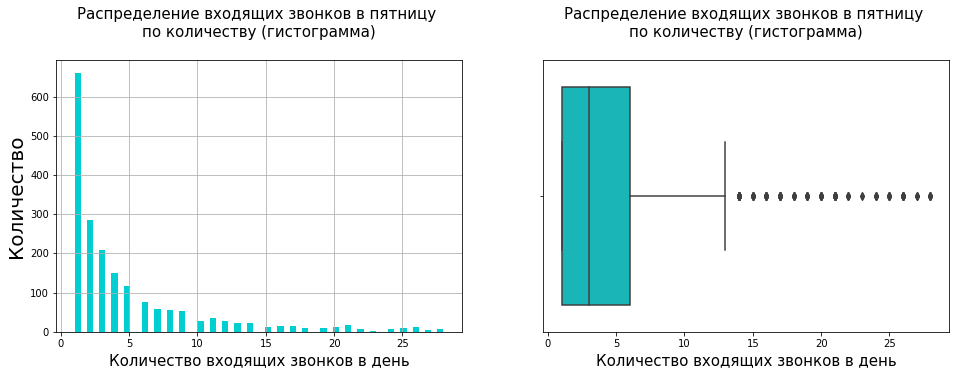

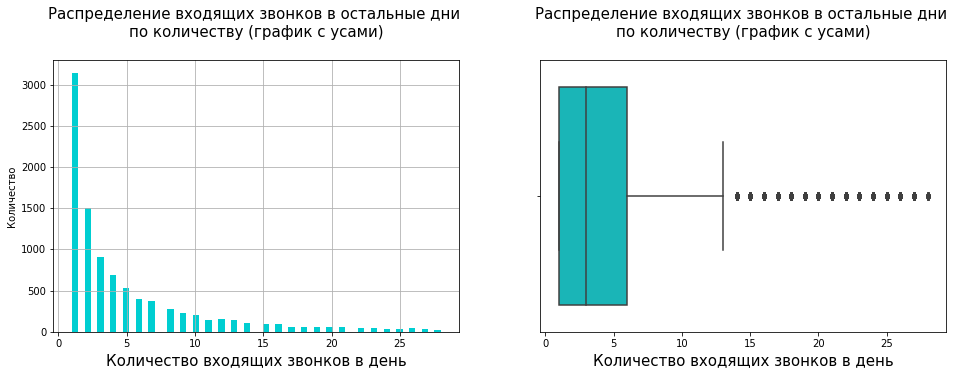

In [118]:
fig, ax = plt.subplots(1,2, figsize=(16,5))

query_1.hist(ax=ax[0], bins=60, color='#00CED1')
sns.boxplot(query_1, ax=ax[1], color='#00CED1')
ax[0].set_xlabel('Количество входящих звонков в день',color='#000000', fontsize=15)
ax[1].set_xlabel('Количество входящих звонков в день', color='#000000', fontsize=15)
ax[0].set_ylabel('Количество', color='#000000', fontsize=20)

ax[0].set_title('Распределение входящих звонков в пятницу \nпо количеству (гистограмма)\n', color='#000000', fontsize=15)
ax[1].set_title('Распределение входящих звонков в пятницу \nпо количеству (гистограмма)\n', color='#000000', fontsize=15)

fig, ax = plt.subplots(1,2, figsize=(16,5))

query_2.hist(ax=ax[0], bins='auto', color='#00CED1')
sns.boxplot(query_2, ax=ax[1], color='#00CED1')
ax[0].set_xlabel('Количество входящих звонков в день', color='#000000', fontsize=15)
ax[1].set_xlabel('Количество входящих звонков в день', color='#000000', fontsize=15)
ax[0].set_ylabel('Количество')

ax[0].set_title('Распределение входящих звонков в остальные дни \nпо количеству (график с усами)\n', color='#000000', fontsize=15)
ax[1].set_title('Распределение входящих звонков в остальные дни \nпо количеству (график с усами)\n', color='#000000', fontsize=15)
plt.show()

In [119]:
query_1.describe()

count    1936.000000
mean        4.778926
std         5.479460
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        28.000000
Name: calls_count, dtype: float64

In [120]:
query_2.describe()

count    9550.000000
mean        4.986178
std         5.578955
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        28.000000
Name: calls_count, dtype: float64

## Выводы:

✆ Максимальное количество звонков было совершено в последний день каждого из зафиксированных месяцев. Можно предположить, что это либо день оплаты абонентом какой-либо услуги, либо день получения этой самой услуги. К сожалению недостаточно "дано:", для совершения более детальных выводов.

✆ Нагрузка на операторов (пиковые дни работы операторов) происходит каждый последний день месяца. Обратим также внимание на то, что в обзвонах количество звонков в последние дни месяца превышает входящие звонки в полтора-два-раза.

✆ Исследование категорий колл-центров по признаку продолжительности разговоров не принесло ожидаемых результатов (нахождение конкретных дат или периодов со сходной нагрузкой продолжительности звонков). Наличие связи между колл-центрами по признаку продолжительности разговоров по датам отсутствует.

###### В процессе исследования неуспешных операторов было выявлено:

✆ По первому признаку неэффективности зафиксировано 76 операторов с пропуском входящих вызовов в совокупной сложности от 114 до 920.

✆ По второму признаку неэффективности зафиксировано 153 оператора заставляющие ждать ответа от 25 секунд до 115 секунд.

✆ По третьему признаку неэффективности зафиксировано 93 оператора совершившие в совокупной сложности от 1 до 2 звонков за весь период.

✆ В итоговую таблицу по неэффективным операторам, принимающим входящие звонки попали 12 операторов. 

✆ В итоговую таблицу неэффективных операторов специализирующихся на обзвонах, попали 68 уникальных оператора.  

###### Выводы по гипотезам.

###### Гипотеза №1

✆ Н0: Время ожидания звонка зависит от тарифного плана;

✆ Н1: Время ожидания звонка не зависит от тарифного плана.



✆ Дольше всех в среднем отвечает тарифный план "А".

✆ За ним идёт тарифный план "С".

✆ Опережает всех по скорости ответа на звонок тарифный план "В".

###### Гипотеза №2

✆ Н0: Количество принятых звонков операторами одинаковое в пятницу и в остальные дни, тогда альтернативной гипотезой.

✆ Н1: Количество принятых звонков операторами в пятницу и в остальные дни различаются.

Гипотеза показывает нам что нет статистического отличия принятых звонков в пятницу и в остальные дни.

## Рекомендации:

✆ Обратить внимание клиента с id: "168252" на большое количество пропущенных значений оператора при исходящих звонках.

✆ Ввести услугу прозрачного оценивания операторов колл-центров . "Нупозвони" это может принести потенциально большее количество клиентов, и усилит мотивацию остаться именно с этим провайдером у уже имеющихся клиентов.